# Import everyting here

In [2]:
import torch.utils.data
import matplotlib.pyplot as plt
import torch
import scipy.integrate
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger


from Euler import *

%reload_ext autoreload
%autoreload 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Setup Tensorboard

In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs --port 6006

Launching TensorBoard...

In [5]:
# train_dataset[0] --> trajectory sets as dict
# train_dataset[0]["traj"] --> first trajectory set 
# train_dataset[0]["traj_shifted"] --> first trajectory set shifted by one (targets)
train_dataset = None # 100x10x2
validation_dataset = None
test_dataset = None

# Create dataset

FIRST VALUE:  1.016277005951237 1.5971402631433298
LAST VALUE:  1.2055613348733203e-07 9.413300584002939e-08
############################################################################# ARDA $$$$$$$$$$$$$$$$$$$$
FIRST VALUE:  -1.4515703951331425 -0.9018363705854422
LAST VALUE:  -8.188240160352102e-08 1.50882805668524e-09


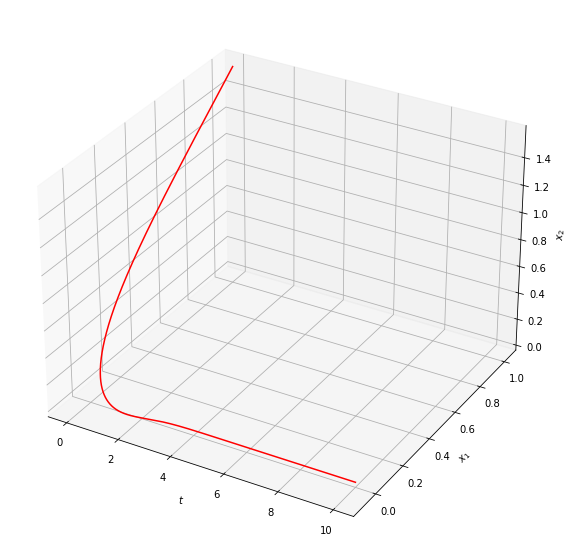

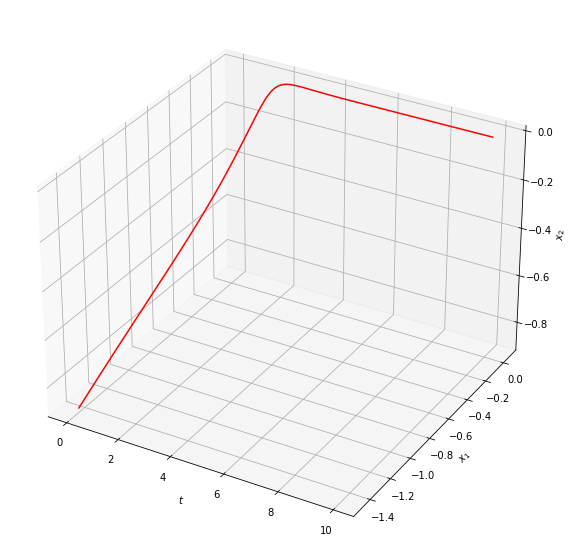

In [6]:
alpha = -1.8
delta_t = 0.001

def get_derivatives(x1, x2, alpha):
    """
    andronov hopf change name
    """
    return alpha * x1 - x2 - x1 * (x1 ** 2 + x2 ** 2), x1 + alpha * x2 - x2 * (x1 ** 2 + x2 ** 2)

start_positions = np.random.uniform(-2, 2, (1000, 2))
sols = []
t_eval = np.arange(0, 10, delta_t)

for start_position in start_positions:
    sol = scipy.integrate.solve_ivp(lambda t, y: get_derivatives(y[0], y[1], alpha), (0, 10) , start_position, t_eval=t_eval)
    sols.append(sol.y)

# plot both trajectories in 3D
fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, sols[0][0], sols[0][1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")

print("FIRST VALUE: ", sols[0][0][0], sols[0][1][0])
print("LAST VALUE: ", sols[0][0][-1], sols[0][1][-1])

# plot both trajectories in 3D
fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, sols[999][0], sols[999][1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")

print("FIRST VALUE: ", sols[999][0][0], sols[999][1][0])
print("LAST VALUE: ", sols[999][0][-1], sols[999][1][-1])

# some deep shit here

In [26]:
train_dataset_values = np.array(sols)

train_dataset_targets = np.delete(train_dataset_values, 0, axis=-1)
train_dataset_values = np.delete(train_dataset_values, -1, axis=-1)

print("train_dataset_values shape: ", train_dataset_values.shape)
print("train_dataset_targets shape: ", train_dataset_targets.shape)

train_dataset_values = np.moveaxis(train_dataset_values, 1, -1).reshape((train_dataset_values.shape[0] * train_dataset_values.shape[2], 2))
print("train_dataset_values shape: ", train_dataset_values.shape)

train_dataset_targets = np.moveaxis(train_dataset_targets, 1, -1).reshape((train_dataset_targets.shape[0] * train_dataset_targets.shape[2], 2))
print("train_dataset_targets shape: ", train_dataset_targets.shape)

train_dataset = np.stack((train_dataset_values, train_dataset_targets))
print("train_dataset shape: ", train_dataset.shape)

train_dataset_values shape:  (200, 2, 9999)
train_dataset_targets shape:  (200, 2, 9999)
train_dataset_values shape:  (1999800, 2)
train_dataset_targets shape:  (1999800, 2)
train_dataset shape:  (2, 1999800, 2)


In [ ]:
"""
train_dataset = np.stack((train_dataset_values, train_dataset_targets))
print("train_dataset shape: ", train_dataset.shape)

train_dataset = np.moveaxis(train_dataset, 0, 1)
print("train_dataset shape: ", train_dataset.shape)

# As one can see, we could successfully generate the targets!
#print(train_dataset_values[0, :, :10])
#print(train_dataset_targets[0, :, :10])


#values_x = train_dataset_values[:, 0, :]
#values_y = train_dataset_values[:, 1, :]

#A = np.reshape(train_dataset_values, (1000, 9999, 2))
#print(A[0, :10, :])

#train_dataset_targets =

#(1000, 10000, 10000)

#((10000000, 2), (10000000, 2))
"""

# Define hyperparameters

In [19]:
hparams = {
    "hidden_layer_1": 512,
    "hidden_layer_2": 512,
    "hidden_layer_3": 512,
    "delta_t": delta_t,
    "batch_size": 256,
    "learning_rate": 1e-3,
    "num_workers": 8,
}

In [20]:
model = Euler(hparams)

# Validation set

In [22]:
start_positions = np.random.uniform(-2, 2, (200, 2))

sols = []
t_eval = np.arange(0, 10, delta_t)

for start_position in start_positions:
    sol = scipy.integrate.solve_ivp(lambda t, y: get_derivatives(y[0], y[1], alpha), (0, 10) , start_position, t_eval=t_eval)
    sols.append(sol.y)
    
validation_dataset_values = np.array(sols)

validation_dataset_targets = np.delete(validation_dataset_values, (0), axis=-1)
validation_dataset_values = np.delete(validation_dataset_values, (-1), axis=-1)

validation_dataset_values = np.moveaxis(validation_dataset_values, 1, -1)

validation_dataset_targets = np.moveaxis(validation_dataset_targets, 1, -1)

validation_dataset = np.stack((validation_dataset_values, validation_dataset_targets))

validation_dataset = np.moveaxis(validation_dataset, 0, 1)

def evaluate_model(model, dataset):
    """
    TODO
    """
    model.eval()
    model.to(device)
    criterion = torch.nn.MSELoss()
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
    loss = 0
    for batch in dataloader:
        traj, traj_shifted = batch
        
        traj = traj.to(device)
        traj_shifted = traj_shifted.to(device)
        
        x = torch.flatten(traj).to(device)
        y = torch.flatten(traj_shifted).to(device)
        
        pred = model.forward(x.float()).to(device)
        
        loss += criterion(pred, y.float()).item()
    return 1.0 / (2 * (loss/len(dataloader)))


def recreate_trajectory(model, start_position, t_start, t_end, delta_t):
    """
    TODO
    """
    trajectory = [start_position]
    last_traj = torch.tensor(start_position)
    
    last_traj = last_traj.to(device)
    
    t0 = t_start
    while t0 <= t_end:
        last_traj = last_traj + delta_t * model(last_traj)
        trajectory.append(last_traj)
        
        t0 += delta_t
        
    return trajectory


print("Score of the Model before training:", evaluate_model(model, validation_dataset))

# plot the first one
recreation = recreate_trajectory(model, start_positions[0], t_eval[0], t_eval[-1], delta_t)
recreation = np.array(recreation)

fig = plt.figure(figsize=(10, 10))
ax0 = plt.axes(projection="3d")
ax0.plot(t_eval, recreation[0], recreation[1], label=r"Trajectory with starting point $(-3, -3)$", color="r")

ax0.set_xlabel(r"$t$")
ax0.set_ylabel(r"$x_1$")
ax0.set_zlabel(r"$x_2$")


print("FIRST VALUE: ", recreation[0][0], recreation[0][1])
print("LAST VALUE: ", recreation[-1][0], recreation[-1][1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x19998 and 2x512)

In [28]:
train_dataloader = torch.utils.data.DataLoader(train_dataset,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)
validation__dataloader = torch.utils.data.DataLoader(validation_dataset,
                                         shuffle=False,
                                         batch_size=hparams["batch_size"],
                                         num_workers=8)

In [ ]:
trainer = pl.Trainer(
    max_epochs=5,
    log_every_n_steps=1,
    gpus=1 if torch.cuda.is_available() else None
)

trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 527 K 
-------------------------------------
527 K     Trainable params
0         Non-trainable params
527 K     Total params
2.111     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [12]:
print("Score of the Model after training:", evaluate_model(model, validation_dataset))

Score of the Model after training: 2012554.1318614823
